In [6]:
import json
from pandas.io.json import json_normalize                                                                                                                                                           
import pandas as pd
import numpy as np
import re

In [7]:
f= open("amazon-meta.txt", "r")
file_list = f.read().split('\n\n') # split by double return spaces

In [13]:
file_list[1].split('\n') # view the first product

['Id:   0', 'ASIN: 0771044445', '  discontinued product']

In [19]:
file_list[2].split('\n') # view the second product

['Id:   1',
 'ASIN: 0827229534',
 '  title: Patterns of Preaching: A Sermon Sampler',
 '  group: Book',
 '  salesrank: 396585',
 '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 '  categories: 2',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '  reviews: total: 2  downloaded: 2  avg rating: 5',
 '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
 '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5']

In [17]:
#d = {}
#d['categories'] = []
line = "   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]"
items = line.split(":")
key = re.sub(pattern=' ',repl= '',string=items[0]) 
key
d['categories'].append({'category': key})
d

{'categories': [{'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'},
  {'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]'}]}

In [27]:
# Define a function to parse a list of lines into a dictionary 

def get_dict(list_lines, spli_s ): # the character for splitting is usually ":"
    d = {}
    if len(list_lines) > 8: # filter out those products with no reviews
        d['individuals'] = []
        d['cat_entries'] = []
        
    for i in range(len(list_lines)):
        line = list_lines[i]
        items = line.split(spli_s)
        
        # collapse the key into a character string with no empty space 
        key = re.sub(pattern=' ',repl= '',string=items[0]) 
        
        if '|' in items[0][:10]: # those starting with '|' are categories
            d['cat_entries'].append({'category': key})  # created nested list of dictionaries
            next # break out to the next loop
            
        elif len(items) < 4:
            val = ':'.join(items[1:])
            d[key] = val
        else:
            # put the items back to its original form
            temp_val = ':'.join(items[1:])
            
            if key[-5:]== 'tomer': # check if it was a specific review
                temp_val = 'date:' + ':'.join(items) # add 'date' to the original line
                #key = 'individuals:' # master layer to all the inidividual reviews

        # parse the meta info on reviews, use 'findall' to divide into a list of "key:val" 
            nest_dic = get_dict(re.findall(r"\w+:\s+\S+", temp_val), ':')
            if key[-5:]== 'tomer':
                d['individuals'].append(nest_dic) # nested reviews
            else: # super long item
                d[key] = nest_dic 
    return d
get_dict(file_list[2].split('\n'), ':')

{'ASIN': ' 0827229534',
 'Id': '   1',
 'cat_entries': [{'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]'},
  {'category': '|Books[283155]|Subjects[1000]|Religion&Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]'}],
 'categories': ' 2',
 'group': ' Book',
 'individuals': [{'cutomer': ' A2JW67OY8U6HHK',
   'date': '    2000-7-28',
   'helpful': '   9',
   'rating': ' 5',
   'votes': '  10'},
  {'cutomer': ' A2VE83MZF98ITY',
   'date': '    2003-12-14',
   'helpful': '   5',
   'rating': ' 5',
   'votes': '   6'}],
 'reviews': {'downloaded': ' 2', 'rating': ' 5', 'total': ' 2'},
 'salesrank': ' 396585',
 'similar': ' 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 'title': ' Patterns of Preaching: A Sermon Sampler'}

In [28]:
all_dict = [get_dict(L.split('\n'), ':') for L in file_list if len(L.split('\n')) > 8]
# keep only the ones with all the keys

In [29]:
# print out all the keys in the complete dictionary
all_dict[2].keys()

dict_keys(['similar', 'group', 'salesrank', 'ASIN', 'categories', 'title', 'individuals', 'cat_entries', 'Id', 'reviews'])

In [76]:
with open('meta-data.json', 'w') as outfile:
    #json.dump(all_dict, outfile)
    json.dumps([dict(pn) for pn in all_dict], outfile) #save the file as json format

In [95]:

#json_df = pd.read_json('meta-data.json')
#json_df.head()

In [32]:
data_raw = json_normalize(all_dict, 'individuals', 
                          ['Id','ASIN','title','group','categories','salesrank','similar',
                           ['reviews', 'total']
                          ]) # some may have no ratings at all

In [98]:
data_raw.head()

,cutomer,date,helpful,individuals,rating,votes,reviews.total,group,salesrank,category,similar,categories,Id,title,ASIN
0,A2JW67OY8U6HHK,2000-7-28,9,[],5,10,2,Book,396585,|Books[283155]|Subjects[1000]|Religion&Spiritu...,5 0804215715 156101074X 0687023955 068707...,2,1,Patterns of Preaching: A Sermon Sampler,0827229534
1,A2VE83MZF98ITY,2003-12-14,5,[],5,6,2,Book,396585,|Books[283155]|Subjects[1000]|Religion&Spiritu...,5 0804215715 156101074X 0687023955 068707...,2,1,Patterns of Preaching: A Sermon Sampler,0827229534
2,A11NCO6YTE4BTJ,2001-12-16,4,[],5,5,12,Book,168596,|Books[283155]|Subjects[1000]|Religion&Spiritu...,5 0738700827 1567184960 1567182836 073870...,2,2,Candlemas: Feast of Flames,0738700797
3,A9CQ3PLRNIR83,2002-1-7,5,[],4,5,12,Book,168596,|Books[283155]|Subjects[1000]|Religion&Spiritu...,5 0738700827 1567184960 1567182836 073870...,2,2,Candlemas: Feast of Flames,0738700797
4,A13SG9ACZ9O5IM,2002-1-24,8,[],5,8,12,Book,168596,|Books[283155]|Subjects[1000]|Religion&Spiritu...,5 0738700827 1567184960 1567182836 073870...,2,2,Candlemas: Feast of Flames,0738700797


In [99]:
data_raw = data_raw.drop('individuals', axis = 1)
data_raw.to_csv('meta-data_raw.csv')

## 1. Trustworthiness of ratings
Ratings are susceptible to manipulation, bias etc. 
<p>What can you say (quantitatively
speaking) about the ratings in this dataset?

In [62]:
import matplotlib.pyplot as plt

In [103]:
data_raw.rating = data_raw.rating.astype(int)
data_raw.salesrank = data_raw.salesrank.astype(int)

In [115]:
# aggregate against each product
avg_rating = data_raw.groupby('ASIN', as_index=False)[['rating', 'salesrank']].aggregate(np.mean)

In [116]:
avg_rating.head()

,ASIN,rating,salesrank
0,0001047655,3.766667,1116690.0
1,0001053736,4.600000,53150.0
2,0001053744,5.000000,500890.0
3,0001054600,4.159574,2449141.0
4,0001057170,3.500000,708137.0


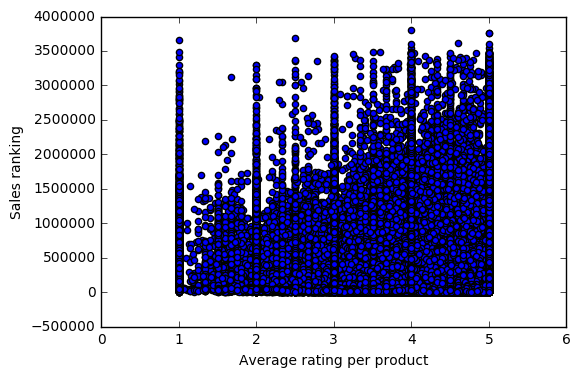

In [119]:
# compare review rating to the sales rank
plt.scatter(avg_rating.rating, avg_rating.salesrank)
plt.xlabel('Average rating per product')
plt.ylabel('Sales ranking')
plt.show()

* There is sales ranking of the whole range for all average product rating
* It even seems that lower rating products have better ranks (small number)
* Thus ratings are not reflective of popularity of products and very likely biased.

In [122]:
avg_rating.corr() 

,rating,salesrank
rating,1.000000,-0.017756
salesrank,-0.017756,1.000000


In [123]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [124]:
m = ols('salesrank ~ rating', avg_rating).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              salesrank   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     127.0
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           1.87e-29
Time:                        21:17:04   Log-Likelihood:            -5.7680e+06
No. Observations:              402724   AIC:                         1.154e+07
Df Residuals:                  402722   BIC:                         1.154e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.945e+05   3777.820    104.412      0.0

## 2. Category bloat
Consider the product group named 'Books'. 
<p>a. Is there redundancy in the categorization? How can it be identified/removed?
<p>b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?

In [33]:
cat_raw = json_normalize(all_dict, 'cat_entries', 
                          ['ASIN','group','categories'])

In [36]:
cat_raw.head()

,category,categories,ASIN,group
0,|Books[283155]|Subjects[1000]|Religion&Spiritu...,2,0827229534,Book
1,|Books[283155]|Subjects[1000]|Religion&Spiritu...,2,0827229534,Book
2,|Books[283155]|Subjects[1000]|Religion&Spiritu...,2,0738700797,Book
3,|Books[283155]|Subjects[1000]|Religion&Spiritu...,2,0738700797,Book
4,|Books[283155]|Subjects[1000]|Home&Garden[48]|...,1,0486287785,Book


In [136]:
cat_raw.group.unique()

array([' Book', ' Music', ' DVD', ' Video', ' Toy', ' Video Games',
       ' Software', ' Baby Product', ' CE', ' Sports'], dtype=object)

In [49]:
# subset to only books and category related columns
cat_raw.group = cat_raw.group.astype(str)
cat_raw.group = cat_raw.group.apply(lambda x: re.sub(' ','', x)) # remove empty strings

In [51]:
books_data = cat_raw.loc[cat_raw['group']=="Book",: ]
books_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440329 entries, 0 to 2509689
Data columns (total 4 columns):
category      1440329 non-null object
categories    1440329 non-null object
ASIN          1440329 non-null object
group         1440329 non-null object
dtypes: object(4)
memory usage: 54.9+ MB


In [57]:
# change types of the variables
books_data.category = books_data.category.astype(str)
books_data.ASIN = books_data.ASIN.astype(str)
books_data.categories = books_data.categories.astype(int)

print('Total products',len(books_data.ASIN.unique()))
print('Total categories', len(books_data.category.unique()))

/Users/yizhao/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Total products 375139
Total categories 12849


* The number of unique category entries is 3.4% of the number of products
* Redundant categoreis can be removed according to the representation of that category in the whole dataset

In [65]:
# extract words for the categories
cat_all = books_data.category.apply(
                    lambda x: re.findall('[a-zA-Z]+',x))


cat_all[:5] # a list of category words in sequence

0    [Books, Subjects, Religion, Spirituality, Chri...
1    [Books, Subjects, Religion, Spirituality, Chri...
2    [Books, Subjects, Religion, Spirituality, Eart...
3    [Books, Subjects, Religion, Spirituality, Eart...
4    [Books, Subjects, Home, Garden, Crafts, Hobbie...
Name: category, dtype: object

In [82]:
# get the number of unique categories from flattening the array
L = cat_all.as_matrix()
all_catNames = [item for sublist in L for item in sublist]
n_catNames = len(set(all_catNames))
print("Number of unique category names:" , n_catNames)

Number of unique category names: 9118


In [66]:

new_cats =pd.DataFrame({'Original': cat_all.apply(lambda x: '_'.join(x)),
                        'Level_1': cat_all.apply(lambda x: x[-1]),
                        'Level_2': cat_all.apply(lambda x: x[-2]),
                        'Level_no1': cat_all.apply(lambda x: '_'.join(x[:-1])),
                        'Level_no2': cat_all.apply(lambda x: '_'.join(x[:-2]))
                       }, dtype = str) 
new_cats.head()

,Level_1,Level_2,Level_no1,Level_no2,Original
0,Preaching,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
1,Sermons,Clergy,Books_Subjects_Religion_Spirituality_Christian...,Books_Subjects_Religion_Spirituality_Christianity,Books_Subjects_Religion_Spirituality_Christian...
2,Wicca,BasedReligions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth,Books_Subjects_Religion_Spirituality_Earth_Bas...
3,Witchcraft,BasedReligions,Books_Subjects_Religion_Spirituality_Earth_Bas...,Books_Subjects_Religion_Spirituality_Earth,Books_Subjects_Religion_Spirituality_Earth_Bas...
4,General,Hobbies,Books_Subjects_Home_Garden_Crafts_Hobbies,Books_Subjects_Home_Garden_Crafts,Books_Subjects_Home_Garden_Crafts_Hobbies_General


In [67]:
size_rest = new_cats.drop_duplicates(
                                    subset='Original').groupby('Level_no1').size(
                ).sort_values(ascending = False)
size_rest

Level_no1
Books_Subjects_Reference_Dictionaries_Thesauruses_ForeignLanguage                               52
Books_Subjects_Home_Garden_Crafts_Hobbies                                                       49
Books_Formats_SheetMusic_Scores_Composers                                                       43
Books_Subjects_Health_Mind_Body_Disorders_Diseases                                              41
Books_Subjects_History_Africa                                                                   40
Books_Subjects_History_Europe                                                                   40
Books_Subjects_History_Americas_UnitedStates_State_Local_ByState                                36
Books_Subjects_Home_Garden_Antiques_Collectibles                                                34
Books_Subjects_Travel_GuidebookSeries                                                           30
Amazon_comStores_Travel_Categories_TravelBooks_GuidebookSeries                                  30


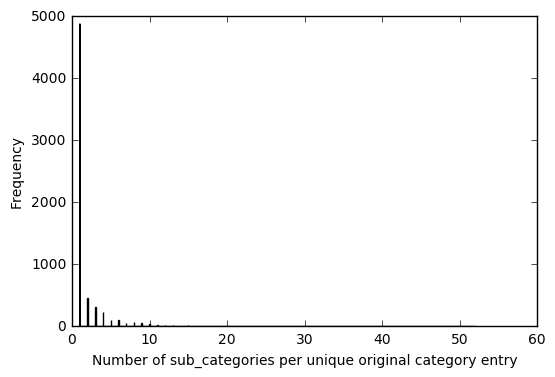

In [69]:
plt.hist(size_rest, 1000) # set 1000 bins
plt.xlabel('Number of sub_categories per unique original category entry')
plt.ylabel('Frequency')
plt.show()

* When there is only one sub-category per category entry, that sub-category can be removed

In [72]:
n_original = len(new_cats.Original.unique())
print('The number of categories with one sub-category:',
 sum(size_rest<2))
print('\nThe original unique category entries:' , n_original)

The number of categories with one sub-category: 4876

The original unique category entries: 12786


* That means if we remove 4876 categories (53% of unique category names), the number of unique category entries remain the same 

In [83]:
# repeat the same step to remove the categories from the second to last level 
#that has only on unique sub category
size_rest2 = new_cats.loc[new_cats.Level_no1.isin(size_rest.index.values[size_rest==1]), :].groupby(
    'Level_no2').size().sort_values(ascending = False)
size_rest2

Level_no2
Amazon_comStores_Home_Office_Business                                                             18438
Books_Subjects_Business                                                                           18436
Books_Subjects_Computers                                                                           8660
Books_SpecialtyStores                                                                              7896
Books_Subjects_Computers_Internet                                                                  5201
Books_Subjects_Children_sBooks_Literature                                                          4097
Books_Subjects_Nonfiction_Politics                                                                 3413
Books_Subjects_History_Americas_UnitedStates                                                       3392
Books_Subjects_Children_sBooks_Literature_ScienceFiction_Fantasy_Mystery_Horror_ScienceFiction     3286
Books_Subjects_Religion_Spirituality_Christianity_Refe

In [84]:
print('The number of categories with one sub-category in the last two layers:',
 sum(size_rest2 == 1))

The number of categories with one sub-category in the last two layers: 155


* That means if we remove 4876 + 155 = 5031 categories (55% of unique category names), the number of unique category entries remain the same

In [85]:
print('The number of categories with two sub-category:',
 sum(size_rest == 2))

The number of categories with two sub-category: 461


In [89]:
print(n_original)
n_catNames

12786


9118

* That means if we remove 4876 + 155 + 461 *2 = 5953 categories (65% of unique category names), the number of unique category entries reduces by 461, or 3.6%.

In [88]:
print('The number of categories with two sub-category second to last category:',
 sum(size_rest2 == 2))

The number of categories with two sub-category second to last category: 62


* That means if we remove 4876 + 155 + 461 \*2 + 62 \* 2 = 6077 categories (67% of unique category names), the number of unique category entries reduces by 461 + 62, or 4.1%.
* And we can continue this on and on until 90% of categories are removed with less than 10% of category entries lost

In [91]:
print('The number of categories with three sub-category :',
 sum(size_rest == 3))

The number of categories with three sub-category : 319


That means if we remove 4876 + 155 + 461\*2 + 62\*2 + 319\*3 = 7034 categories (77% of unique category names), the number of unique category entries reduces by 461 + 62 + 319\*2 = 1161, or 9%